In [0]:
from keras.datasets import mnist

(train_data, train_label), (test_data, test_label) = mnist.load_data()

In [0]:
train_data.shape, test_data.shape

((60000, 28, 28), (10000, 28, 28))

In [0]:
random_dim = 100

In [0]:
# generator

from keras.models import Sequential
from keras.layers import Dense,BatchNormalization

generator = Sequential()

generator.add(Dense(256,activation="relu",input_shape=(random_dim,)))
generator.add(BatchNormalization())
generator.add(Dense(512,activation="relu"))
generator.add(BatchNormalization())
generator.add(Dense(784,activation="tanh"))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               25856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [0]:
# discriminator

from keras.layers import Dropout

discriminator = Sequential()

discriminator.add(Dense(1024, input_shape=(784,), activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total para

In [0]:
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [0]:
from keras.models import Model
from keras.layers import Input

for i in discriminator.layers:
  i.trainable = False

# Model建立Input層
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)

gan = Model(inputs=gan_input, outputs=gan_output)
gan.summary()

gan.compile(optimizer="adam",loss="binary_crossentropy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [0]:
# 資料處理
# discriminator輸入調整為784

train_data_reshape = (train_data.reshape(60000, 784)-127.5)/127.5
test_data_reshape = (test_data.reshape(10000, 784)-127.5)/127.5

In [0]:
# 先訓練discriminator
import numpy as np

epoch = 100
batch = 200

for i in range(epoch):
  for j in range(int(train_data.shape[0]/batch)):
    # 隨機找出200個檔案
    idx = np.random.randint(0, train_data.shape[0], batch)
    imgs = train_data_reshape[idx]
    
    # 製造真假答案矩陣
    fake = np.zeros((batch, 1))
    real = np.ones((batch, 1))
    
    # generator創作假圖
    noise = np.random.normal(0, 1, (batch, random_dim))
    fake_imgs = generator.predict(noise) 
    
    d_loss_fake = discriminator.train_on_batch(fake_imgs,fake)
    d_loss_real = discriminator.train_on_batch(imgs,real)
    
    d_loss = (d_loss_fake[0] + d_loss_real[0]) / 2
    
    noise = np.random.normal(0, 1, (batch, random_dim))
    g_loss = gan.train_on_batch(noise, real) 
  if (i+1)%10 ==0:
    dash = "-" * 15
    print(dash, "epoch", i + 1, dash)
    print("Discriminator loss:", d_loss)
    print("Generator loss:", g_loss)
    
# 互相拉扯 穩定即可

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


--------------- epoch 10 ---------------
Discriminator loss: 0.629177451133728
Generator loss: 0.92115206
--------------- epoch 20 ---------------
Discriminator loss: 0.5973745584487915
Generator loss: 0.9520188
--------------- epoch 30 ---------------
Discriminator loss: 0.59412682056427
Generator loss: 0.90570307
--------------- epoch 40 ---------------
Discriminator loss: 0.6425879597663879
Generator loss: 0.9911542
--------------- epoch 50 ---------------
Discriminator loss: 0.5690914392471313
Generator loss: 0.9809205
--------------- epoch 60 ---------------
Discriminator loss: 0.5965776443481445
Generator loss: 0.9766114
--------------- epoch 70 ---------------
Discriminator loss: 0.5694677829742432
Generator loss: 1.0719061
--------------- epoch 80 ---------------
Discriminator loss: 0.5339670181274414
Generator loss: 1.099643
--------------- epoch 90 ---------------
Discriminator loss: 0.527122974395752
Generator loss: 1.2740278
--------------- epoch 100 ---------------
Discrim

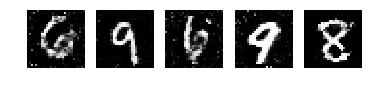

In [0]:
import matplotlib.pyplot as plt
example = 5

noise = np.random.normal(0, 1, (example, random_dim))
gen_imgs = generator.predict(noise)

gen_imgs = gen_imgs*127.5+127.5

gen_imgs = gen_imgs.reshape(example,28,28)

for idx in range(gen_imgs.shape[0]):
  plt.subplot(1, example, idx+1)
  plt.axis('off')
  plt.imshow(gen_imgs[idx], cmap="gray")